# Load the Instacart dataset

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.0.0+cu118


In [2]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 45.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import pandas as pd

In [4]:
train_e = pd.read_parquet('train_labels_neg.parquet')
val_e = pd.read_parquet('val_labels_neg.parquet')
test_e = pd.read_parquet('test_labels_neg.parquet')

In [5]:
print(len(train_e))
print(len(val_e))
print(len(test_e))

661052
661678
656406


In [6]:
# retrive the existing edges for node2vec training
pos_train_edge = train_e[train_e['label']==1]
print(len(pos_train_edge))
pos_val_edge = val_e[val_e['label']==1]
print(len(pos_val_edge))
pos_test_edge = test_e[test_e['label']==1]
print(len(pos_test_edge))

#pos_edge = pd.concat([pos_train_edge, pos_val_edge], ignore_index=True)
pos_edge = pos_train_edge
print(len(pos_edge))

330526
330839
328203
330526


In [7]:
class BipartiteData(Data):
    def __init__(self, edge_index=None, x_s=None, x_t=None):
        super().__init__()
        self.edge_index = edge_index
        self.x_s = x_s
        self.x_t = x_t
    
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index':
            return torch.tensor([[self.x_s.size(0)], [self.x_t.size(0)]])
        else:
            return super().__inc__(key, value, *args, **kwargs)

In [8]:
pos_edge_idx = pos_edge.loc[:, ["user_id", "product_id"]].to_numpy().T
pos_edge_data=BipartiteData(edge_index=pos_edge_idx)
# convert the edge_index into tensor
pos_edge_data.edge_index = torch.from_numpy(pos_edge_data.edge_index)

In [9]:
print(pos_edge_data.edge_index)
print(pos_edge_data.edge_index.shape)

tensor([[     1,      1,      2,  ..., 206206, 206209, 206209],
        [ 46149,  49235,  12258,  ...,  16896,  48370,  40310]])
torch.Size([2, 330526])


# Node2Vec embedding

In [10]:
# import library
from torch_geometric.nn import Node2Vec
import torch_geometric.utils
import os.path as osp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
# check if cuda is available to send the model and tensors to the GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
model = Node2Vec(pos_edge_data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=2)  # data loader to speed the train 
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)  # initzialize the optimizer 

In [12]:
def train():
    model.train() # put model in the train model
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad() # set the gradient to zero
        loss = model.loss(pos_rw.to(device), neg_rw.to(device)) # compute the loss for the batch
        loss.backward()
        optimizer.step() # optimize the parameters
        total_loss += loss.item()
    return total_loss / len(loader)


for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 10, Loss: 0.7298
Epoch: 20, Loss: 0.7308
Epoch: 30, Loss: 0.7319
Epoch: 40, Loss: 0.7320
Epoch: 50, Loss: 0.7318
Epoch: 60, Loss: 0.7318
Epoch: 70, Loss: 0.7317
Epoch: 80, Loss: 0.7316
Epoch: 90, Loss: 0.7316
Epoch: 100, Loss: 0.7316


In [13]:
z = model()

# visualize node mbedding

In [14]:
# from tensor to numpy
emb_128 = z.detach().cpu().numpy()

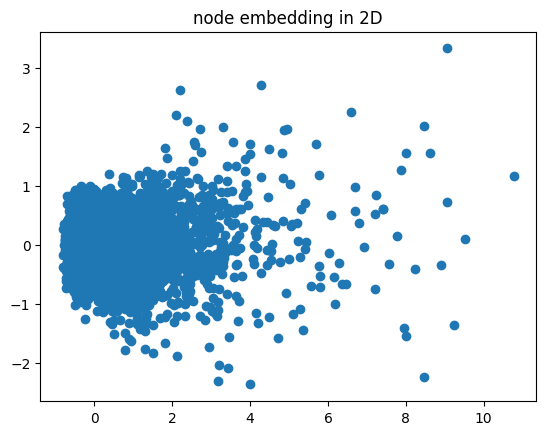

In [15]:
from sklearn.decomposition import PCA
# fit and transform using PCA
pca = PCA(n_components=2)
emb2d = pca.fit_transform(emb_128)


plt.title("node embedding in 2D")
plt.scatter(emb2d[:,0],emb2d[:,1])
plt.show()

# Compute edge embedding using the Node2Vec embedding
using concatenate

In [16]:
# retrieving train/test edge from the pre-processed data set
print(train_e.head(5))
X_train = torch.from_numpy(train_e.loc[:, ["user_id", "product_id"]].values.T)
print(X_train[:5])
y_train = torch.from_numpy(train_e.loc[:, ["label"]].values.T).flatten()
print(y_train[:5])

print(test_e.head(5))
X_test = torch.from_numpy(test_e.loc[:, ["user_id", "product_id"]].values.T)
print(X_test[:5])
y_test = torch.from_numpy(test_e.loc[:, ["label"]].values.T).flatten()
print(y_test[:5])

print(emb_128[1])

   user_id  product_id  label
0        1       46149      1
1        1       49235      1
2        1       32022      0
3        1       44593      0
4        2       47186      0
tensor([[     1,      1,      1,  ..., 206209, 206209, 206209],
        [ 46149,  49235,  32022,  ...,  40310,  27857,  46898]])
tensor([1, 1, 0, 0, 0])
   user_id  product_id  label
0        1       35951      1
1        1       38928      1
2        1       39657      1
3        1        1838      0
4        1       30792      0
tensor([[     1,      1,      1,  ..., 206209, 206209, 206209],
        [ 35951,  38928,  39657,  ...,   6567,  28818,  37274]])
tensor([1, 1, 1, 0, 0])
[ 1.70487225e-01  3.39598864e-01  6.64327517e-02 -2.80383468e-01
 -1.31279096e-01  1.25192419e-01 -3.26078907e-02  1.45907313e-01
  1.26092061e-02 -1.15788750e-01  4.25798520e-02  7.01754587e-04
 -2.47483160e-02 -1.00171283e-01 -1.35032535e-01  1.66805133e-01
 -2.85082981e-02  5.38666546e-02 -6.36942312e-02 -1.34197667e-01
  1.49596

In [17]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([2, 661052]) torch.Size([661052])
torch.Size([2, 656406]) torch.Size([656406])


In [18]:
# compute edge embedding
# X_train
X_train_edge_emb = []
for u, v in X_train.t():
    X_train_edge_emb.append(np.concatenate((emb_128[u], emb_128[v]), axis=0))

# X_test
X_test_edge_emb = []
for u, v in X_test.t():
    X_test_edge_emb.append(np.concatenate((emb_128[u], emb_128[v]), axis=0))

# link prediction classifier: MLP classifier

In [19]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train_edge_emb, y_train)
y_preds = mlp_clf.predict(X_test_edge_emb)
y_preds_proba = mlp_clf.predict_proba(X_test_edge_emb)

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
print("Accuracy: %.3f"%accuracy_score(y_test, y_preds))
print("Precision: %.3f"%precision_score(y_test, y_preds))
print("Recall: %.3f"%recall_score(y_test, y_preds))
print("F1_score: %.3f"%f1_score(y_test, y_preds))
print("Auc_roc_score(y_preds): %.3f"%roc_auc_score(y_test, y_preds))
print("Auc_roc_score(y_preds_proba): %.3f"%roc_auc_score(y_test, y_preds_proba[:, 1]))

Accuracy: 0.646
Precision: 0.817
Recall: 0.377
F1_score: 0.516
Auc_roc_score(y_preds): 0.646
Auc_roc_score(y_preds_proba): 0.726


In [21]:
print(roc_auc_score(y_test, y_preds))
print(accuracy_score(y_test, y_preds))

0.6461839166613346
0.6461839166613346
